In [1]:

from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, TimeDistributed, Input, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from datasets import load_dataset


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dset = load_dataset("SEACrowd/liputan6", trust_remote_code=True)

In [3]:
train_data = dset['train']

print("Number of rows in train data:", train_data.num_rows)
print("Number of columns in train data:", train_data.num_columns)
print("Column names:", train_data.column_names)
print("\nSample row:\n", train_data[0]) 

print("\nDataset Info:\n", dset)


Number of rows in train data: 193883
Number of columns in train data: 3
Column names: ['document', 'id', 'summary']

Sample row:
 {'document': 'TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo melaporkan kasus kecelakaan di Jalan Sisingamaraja , Jakarta Selatan , 1 Juni silam itu ke Kepolisian Resor Metro Jaksel . " Kita melaporkan atas dugaan tindak pidana , " tutur Taufik Basari , kuasa hukum keluarga Janu , belum lama ini . Taufik menambahkan , pihaknya ingin Nuri mencabut pernyataan di depan pers , 2 Juni silam . Ia juga ingin Nuri meminta maaf di media atas kejadian itu . Dan juga menyampaikan belasungkawa . Taufik menilai , pernyataan Nuri memutarbalikkan fakta . " Yang kita adukan soal pernyataan-pernyataannya , " ujar dia . Keluarga Janu melaporkan dengan dua tuduhan . Yakni sikap yang tidak menyenangkan dan pencemaran nama baik . Kala itu Nuri menuding mobil ambulans yang menabrak kendaraannya

In [4]:
val_data = dset['validation']

print("Number of rows in train data:", val_data.num_rows)
print("Number of columns in train data:", val_data.num_columns)
print("Column names:", val_data.column_names)
print("\nSample row:\n", val_data[0]) 

print("\nDataset Info:\n", dset)

Number of rows in train data: 10972
Number of columns in train data: 3
Column names: ['document', 'id', 'summary']

Sample row:
 {'document': 'Liputan6 . com , Jakarta : Keinginan untuk menindaklanjuti hasil curah pendapat yang diprakarsai Kwik Kian Gie , semakin mengental . Buktinya , beberapa anggota DPR ngebet membentuk Forum Lobi . Ketua DPR Akbar Tandjung baru-baru ini , mempersilakan para wakil rakyat yang ingin membentuk forum tersebut . Namun , Akbar menegaskan , pembentukan forum tersebut bukan bagian dari mekanisme DPR . Menurut Akbar , hasil curah pendapat 11 November silam , bisa saja dimasukkan dalam agenda dewan . Asalkan , kata Ketua Umum Golkar ini , semua proses harus berjalan sesuai prosedur yang ada . Artinya , itu harus disepakati melalui rapat fraksi dan dibawa ke Badan Musyawarah . " Bila Bamus telah merumuskannya menjadi sebuah usulan agenda , maka dapat dibawa ke rapat paripurna yang nantinya akan menjadi agenda DPR , " kata Akbar . ( YYT/Diah Kusuma dan Prihand

In [5]:
# Assuming dset['train']['document'] and dset['train']['summary'] are your lists of articles and summaries
articles_train = dset['train']['document'][:10000]
highlights_train = dset['train']['summary'][:10000]

articles_val = dset['validation']['document'][:2000]
highlights_val = dset['validation']['summary'][:2000]

# Print to verify the sizes
print(f"Training data size: {len(articles_train)} articles, {len(highlights_train)} highlights")
print(f"Validation data size: {len(articles_val)} articles, {len(highlights_val)} highlights")


Training data size: 10000 articles, 10000 highlights
Validation data size: 2000 articles, 2000 highlights


In [6]:
# Print one article and its corresponding summary
print("Sample Article:\n", articles_train[0])
print("\nSample Summary:\n", highlights_train[0])

Sample Article:
 TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo melaporkan kasus kecelakaan di Jalan Sisingamaraja , Jakarta Selatan , 1 Juni silam itu ke Kepolisian Resor Metro Jaksel . " Kita melaporkan atas dugaan tindak pidana , " tutur Taufik Basari , kuasa hukum keluarga Janu , belum lama ini . Taufik menambahkan , pihaknya ingin Nuri mencabut pernyataan di depan pers , 2 Juni silam . Ia juga ingin Nuri meminta maaf di media atas kejadian itu . Dan juga menyampaikan belasungkawa . Taufik menilai , pernyataan Nuri memutarbalikkan fakta . " Yang kita adukan soal pernyataan-pernyataannya , " ujar dia . Keluarga Janu melaporkan dengan dua tuduhan . Yakni sikap yang tidak menyenangkan dan pencemaran nama baik . Kala itu Nuri menuding mobil ambulans yang menabrak kendaraannya . " Intinya mereka menabrak kita , " ucap Nuri saat jumpa pers waktu itu . Pernyataan disampaikan bintang film Seventeen didam

In [7]:

# Increase num_words to 20,000 and adjust OOV token
vocab_size = 20000
article_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
highlight_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit tokenizers on training data
article_tokenizer.fit_on_texts(articles_train)
highlight_tokenizer.fit_on_texts(highlights_train)

# Print tokenizer word indices
print("Article Tokenizer Word Index:")
print(dict(list(article_tokenizer.word_index.items())[:20])) 

print("\nHighlight Tokenizer Word Index:")
print(dict(list(highlight_tokenizer.word_index.items())[:20])) 

Article Tokenizer Word Index:
{'<OOV>': 1, 'di': 2, 'yang': 3, 'dan': 4, 'ini': 5, 'itu': 6, 'dengan': 7, 'dari': 8, 'untuk': 9, 'dalam': 10, 'ke': 11, 'akan': 12, 'juga': 13, 'tidak': 14, 'com': 15, 'liputan6': 16, 'jakarta': 17, 'mereka': 18, 'tak': 19, 'pada': 20}

Highlight Tokenizer Word Index:
{'<OOV>': 1, 'di': 2, 'yang': 3, 'dan': 4, 'ini': 5, 'dari': 6, 'dengan': 7, 'untuk': 8, 'dalam': 9, 'ke': 10, 'akan': 11, 'itu': 12, 'warga': 13, 'tak': 14, 'karena': 15, 'mereka': 16, 'tidak': 17, 'dua': 18, 'jakarta': 19, 'rumah': 20}


In [8]:

# Convert texts to sequences
article_sequences_train = article_tokenizer.texts_to_sequences(articles_train)
highlight_sequences_train = highlight_tokenizer.texts_to_sequences(highlights_train)
highlight_sequences_val = highlight_tokenizer.texts_to_sequences(highlights_val)

# Print results of texts_to_sequences
print("Article Sequences (Training):")
print(article_sequences_train[:5])  

print("\nHighlight Sequences (Training):")
print(highlight_sequences_train[:5])  

print("\nHighlight Sequences (Validation):")
print(highlight_sequences_val[:5])  



Article Sequences (Training):
[[67, 108, 7499, 11407, 76, 6490, 1, 33, 3060, 3, 911, 186, 178, 2077, 1620, 10931, 184, 14214, 5068, 1017, 72, 693, 2, 71, 1, 17, 130, 54, 822, 122, 6, 11, 132, 602, 752, 2338, 326, 1017, 126, 721, 1106, 1034, 1372, 1215, 1, 1194, 208, 184, 14214, 49, 233, 5, 1215, 558, 723, 336, 6490, 3408, 481, 2, 175, 1205, 87, 822, 122, 69, 13, 336, 6490, 178, 2077, 2, 900, 126, 392, 6, 4, 13, 1180, 8669, 1215, 430, 481, 6490, 1, 2381, 3, 326, 1, 397, 481, 5646, 337, 84, 184, 14214, 1017, 7, 29, 1519, 353, 835, 3, 14, 4352, 4, 3205, 305, 228, 2314, 6, 6490, 2954, 269, 6491, 3, 2930, 6624, 5546, 18, 2930, 326, 1177, 6490, 25, 3734, 1205, 149, 6, 481, 690, 820, 589, 1, 1744, 1, 4022, 5153, 69, 5441, 709, 18020, 930, 6491, 343, 709, 32, 1, 269, 5966, 4805, 3, 7915, 6490, 2724, 82, 5442, 6491, 524, 2, 348, 1587, 4, 304, 2274, 938, 2751, 2724, 269, 6491, 4, 5966, 4805, 3, 11408, 6490, 6492, 2460, 14214, 5068, 165, 709, 18020, 930, 6491, 442, 1009, 67, 191, 2, 269, 6491, 36

In [9]:

max_article_len = 200
max_highlight_len = 200

article_padded_train = pad_sequences(article_sequences_train, maxlen=max_article_len, padding='post')
highlight_padded_train = pad_sequences(highlight_sequences_train, maxlen=max_highlight_len, padding='post')
article_padded_val = pad_sequences(article_tokenizer.texts_to_sequences(articles_val), maxlen=max_article_len, padding='post')
highlight_padded_val = pad_sequences(highlight_sequences_val, maxlen=max_highlight_len, padding='post')

print("Sample Padded Article:\n", article_padded_train[0])
print("\nSample Padded Summary:\n", highlight_padded_train[0])




Sample Padded Article:
 [  122     6    11   132   602   752  2338   326  1017   126   721  1106
  1034  1372  1215     1  1194   208   184 14214    49   233     5  1215
   558   723   336  6490  3408   481     2   175  1205    87   822   122
    69    13   336  6490   178  2077     2   900   126   392     6     4
    13  1180  8669  1215   430   481  6490     1  2381     3   326     1
   397   481  5646   337    84   184 14214  1017     7    29  1519   353
   835     3    14  4352     4  3205   305   228  2314     6  6490  2954
   269  6491     3  2930  6624  5546    18  2930   326  1177  6490    25
  3734  1205   149     6   481   690   820   589     1  1744     1  4022
  5153    69  5441   709 18020   930  6491   343   709    32     1   269
  5966  4805     3  7915  6490  2724    82  5442  6491   524     2   348
  1587     4   304  2274   938  2751  2724   269  6491     4  5966  4805
     3 11408  6490  6492  2460 14214  5068   165   709 18020   930  6491
   442  1009    67   191   

In [10]:
# Define parameters
embedding_dim = 1024
rnn_units = 512

# Define the input layer
inputs = Input(shape=(max_article_len,))

# Embedding layer
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_article_len, trainable=True)(inputs)

# Bidirectional SimpleRNN layer
x = Bidirectional(SimpleRNN(rnn_units, return_sequences=True))(x)

# Attention layer with normalization for stability
attention_output = Attention()([x, x])
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

# Dense output layer
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(attention_output)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 1024)    20480000    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 1024)    1573888     ['embedding[0][0]']              
                                                                                                  
 attention (Attention)          (None, 200, 1024)    0           ['bidirectional[0][0]',          
                                                                  'bidirectional[0][0]']      

In [11]:

# Train model
history = model.fit(
    article_padded_train, highlight_padded_train,
    epochs=10,  # Increase epochs for better training
    batch_size=16,
    validation_data=(article_padded_val, highlight_padded_val)
)


Epoch 1/10
625/625 [==============================] - 2623s 4s/step - loss: 1.5920 - accuracy: 0.8559 - val_loss: 1.0696 - val_accuracy: 0.8896
Epoch 2/10
625/625 [==============================] - 2567s 4s/step - loss: 1.2674 - accuracy: 0.8635 - val_loss: 0.9343 - val_accuracy: 0.8912
Epoch 3/10
625/625 [==============================] - 2595s 4s/step - loss: 1.1747 - accuracy: 0.8653 - val_loss: 0.9242 - val_accuracy: 0.8913
Epoch 4/10
625/625 [==============================] - 2621s 4s/step - loss: 1.1425 - accuracy: 0.8653 - val_loss: 0.9460 - val_accuracy: 0.8893
Epoch 5/10
625/625 [==============================] - 2621s 4s/step - loss: 1.2983 - accuracy: 0.8584 - val_loss: 1.0176 - val_accuracy: 0.8900
Epoch 6/10
625/625 [==============================] - 2639s 4s/step - loss: 1.3696 - accuracy: 0.8630 - val_loss: 1.0106 - val_accuracy: 0.8910
Epoch 7/10
625/625 [==============================] - 2644s 4s/step - loss: 1.3683 - accuracy: 0.8632 - val_loss: 1.1512 - val_accuracy:

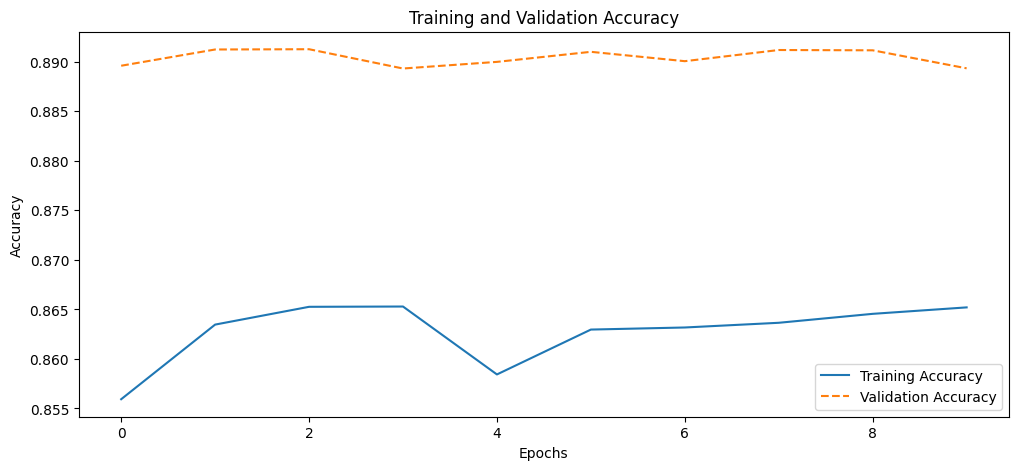

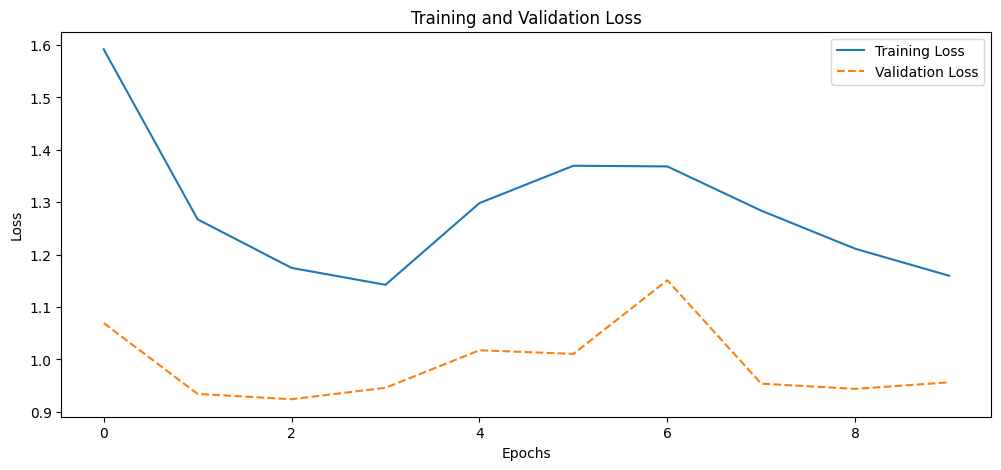

In [12]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:

# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([highlight_tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = article_tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_article_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])

# BLEU Score Evaluation
bleu_scores = []
for i in range(100):
    predicted_summary = generate_summary(articles_val[i])
    reference_summary = decode_sequence(highlight_padded_val[i])
    score = sentence_bleu([reference_summary.split()], predicted_summary.split())
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')




1/1 [==============================] - 0s 83ms/step


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

1/1 [==============================] - 0s 81ms/step
Average BLEU Score: 2.507969569381443e-157


In [14]:
print("artikel berita:", articles_val[30])
print("summary:",highlights_val[30])

artikel berita: Liputan6 . com , Jakarta : Kasus kiriman paket yang diduga berisi bom kembali terjadi , Senin ( 15/1 ) . Kali ini isu bom meresahkan warga Jalan Garuda , Jakarta Pusat . Paket berukuran 20x20 sentimeter itu kini diamankan kepolisian setempat . Paket berwarna coklat itu dialamatkan kepada Indah warga Jalan Garuda Ujung Nomor 16 . Sementara pengirimnya tertera Yuwono dan Ambarawa . Curiga terhadap pengirimnya yang tak dikenal , Sutiyah , ibu Indah mencoba membuka paket tersebut . Setelah melihat banyak kabel , ia kaget . Lalu dengan sigap menelepon polisi . Kepada SCTV warga di sekitar lokasi tetap khawatir . Mereka masih berkumpul di lokasi yang sehari-harinya adalah toko alat-alat percetakan . Kendati , polisi telah mengamankan paket tersebut . ( YYT/Olivia Rosalia dan Irfan Effendi ) .
summary: Ibu Kota Jakarta kembali dikejutkan dengan isu bom . Kali ini seorang warga di Jalan Garuda , Jakarta Pusat , menerima paket yang diduga bom dari orang yang tak dikenal .


In [15]:
input_article = articles_val[30]
predicted_summary = generate_summary(input_article)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 80ms/step
Predicted Summary: warga di di di di di di di di di di di di di yang di


In [16]:
print("artikel berita:", articles_train[30])
print("summary:",highlights_train[30])

artikel berita: Liputan6 . com , Jakarta : Dua dari sepuluh korban kebocoran tabung gas di Tanjungduren , Jakarta Barat , Senin ( 26/7 ) , diperbolehkan pulang dari Rumah Sakit Sumber Waras . Kondisi kedua korban dinilai tidak terlalu parah [ baca : Tabung Elpiji Bocor , Sepuluh Orang Luka ] . Usai kejadian pada Ahad silam , PT Pertamina menjenguk korban kebocoran elpiji ukuran tiga kilogram di RS Sumber Waras , Jakbar . Dalam kesempatan itu Pertamina berjanji menanggung seluruh biaya pengobatan korban . Para korban yang dirawat di rumah sakit mengaku trauma menggunakan tabung gas ukuran 3 kilogram . Sepanjang 2010 , telah terjadi 13 ledakan tabung gas di Jakarta Barat . Dua ledakan di antaranya terjadi di kawasan Tanjungduren Selatan dan Tanjungduren . ( AIS ) .
summary: Dua dari sepuluh korban kebocoran tabung gas di Tanjungduren , Jakbar , diperbolehkan pulang dari RS Sumber Waras . Kondisi keduanya dinilai tidak terlalu parah .


In [17]:
# User input for summarization
user_input = articles_train[30]
predicted_summary = generate_summary(user_input)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 88ms/step
Predicted Summary: warga di di di di di di di di di di di di di di di
